### Heuristic Models
Look at the Seattle weather in the **data** folder. Come up with a heuristic model to predict if it will rain today. Keep in mind this is a time series, which means that you only know what happened historically (before a given date). One example of a heuristic model is: It will rain tomorrow if it rained more than 1 inch (>1.0 PRCP) today. Describe your heuristic model in the next cell.

If minmum tempatrue of yesterday was below the the average, it will rain today.
If PRCP > 0, then it will be rain 

Examples:  
It will rain tomorrow if it rained more than 1 inch (>1.0 PRCP) today
If rained yesterday it will rain today.  
If it rained yesterday or the day before it will rain today.

In [73]:
#here is an example of how to build and populate a hurestic model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import time
import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


from sklearn import metrics
from yellowbrick.model_selection import FeatureImportances

In [74]:
df = pd.read_csv('../data/seattle_weather_1948-2017.csv')

df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


In [76]:
df[pd.isnull(df['PRCP'])]

,DATE,PRCP,TMAX,TMIN,RAIN
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
21067,2005-09-05,NaN,70,52,NaN


In [77]:
df[pd.isnull(df['RAIN'])]

,DATE,PRCP,TMAX,TMIN,RAIN
18415,1998-06-02,NaN,72,52,NaN
18416,1998-06-03,NaN,66,51,NaN
21067,2005-09-05,NaN,70,52,NaN


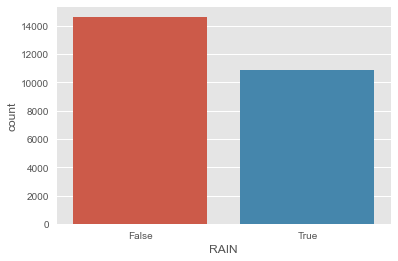

In [78]:
sns.countplot(data=df, x='RAIN')

In [79]:
df['PRCP'].mean()

0.10622162204477956

In [80]:
# Replace null values with False

def RAIN_INSERTION(cols):
    RAIN=cols[0]
    if pd.isnull(RAIN):
        return 'False'
    else:
        return RAIN

In [81]:
# Replace null values with the mean

def PRCP_INSERTION(col):
    PRCP=col[0]
    if pd.isnull(PRCP):
        return df['PRCP'].mean()
    else:
        return PRCP

In [82]:
df['RAIN']=df[['RAIN']].apply(RAIN_INSERTION,axis=1)

In [83]:
df['PRCP']=df[['PRCP']].apply(PRCP_INSERTION,axis=1)

In [84]:
df[pd.isnull(df['RAIN'])]

,DATE,PRCP,TMAX,TMIN,RAIN


In [85]:
df[pd.isnull(df['PRCP'])]

,DATE,PRCP,TMAX,TMIN,RAIN


In [92]:
#Dropping the outliers from TMIN column
df=df.drop(df[df['TMIN']<17 ].index)


In [93]:
#Dropping the outliers from TMAX columns i.e. the value more than 100
df=df.drop(df[(df['TMAX']>97.5) | (df['TMAX']< 21.5)].index)


In [94]:
#Dropping the outliers from PRCP columns i.e. the value more than 0.275
df=df.drop(df[(df['PRCP']>0.25) | (df['PRCP']< -0.15) ].index)

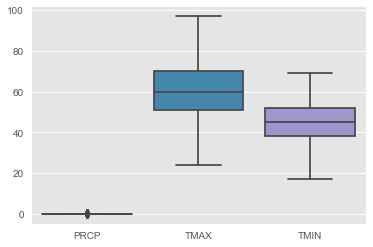

In [95]:
sns.boxplot(data=df)


# Heuristic Model

Build a loop to add your heuristic model guesses as a column to this dataframe

In [96]:
numrows = 21891

#create an empty dataframe to hold 100 values
heuristic_df = pd.DataFrame({'yesterday':[0.0]*numrows,
                             'today':[0.0]*numrows,
                             'tomorrow':[0.0]*numrows,
                             'guess':[False]*numrows, #logical guess
                             'rain_tomorrow':[False]*numrows, #historical observation
                             'correct':[False]*numrows}) #TRUE if your guess matches the historical observation

#sort columns for convience
seq = ['yesterday','today','tomorrow','guess','rain_tomorrow','correct']
heuristic_df = heuristic_df.reindex(columns=seq)

In [97]:
# here is an example loop that populates the dataframe created earlier
# with the total percip from yesterday and today
# then the guess is set to true if rained both yesterday and today 
for z in range(numrows):
    #start at time 2 in the data frame
    i = z + 2
    
    #pull values from the dataframe
    yesterday = df.iloc[(i-2),1]
    today = df.iloc[(i-1),1]
    tomorrow = df.iloc[i,1]
    rain_tomorrow = df.iloc[(i),1]

    
    heuristic_df.iat[z,0] = yesterday
    heuristic_df.iat[z,1] = today
    heuristic_df.iat[z,2] = tomorrow
    heuristic_df.iat[z,3] = False # set guess default to False
    heuristic_df.iat[z,4] = rain_tomorrow
    
    
    ######### uncomment and create your heuristic guess ################
    #if ##### your conditions here #########:
    #    heuristic_df.iat[z,3] = True 
    ####################################################################
    
    if today > 0.0:   # my guess: if it rains today, it will rain tomorrow 
        heuristic_df.iat[z,3] = True    
    
    
    if heuristic_df.iat[z,3] == heuristic_df.iat[z,4]:
        heuristic_df.iat[z,5] = True
    else:
        heuristic_df.iat[z,5] = False

In [134]:
heuristic_df.sample(3)

,yesterday,today,tomorrow,guess,rain_tomorrow,correct
21271,0.0,0.00,0.0,False,False,True
5052,0.0,0.00,0.0,False,False,True
394,0.0,0.01,0.0,True,False,False


### Evaluate the performance of the Heuristic model

***the accuracy of your predicitions***

In [135]:
heuristic_df['correct'].value_counts()/numrows

True     0.693618
False    0.306382
Name: correct, dtype: float64

# Logistic regression - Classifications

In [105]:
X=df.drop(['RAIN','DATE'],axis=1)
y=df['RAIN'] # target varable or label
y=y.astype('str')

X_train,  X_test , y_train, y_test = train_test_split(X, y, test_size=0.4)

print("x train",X_train.shape )
print("y train",y_train.shape )
print("x test",X_test.shape )
print("y test",y_test.shape )

x train (13135, 3)
y train (13135,)
x test (8758, 3)
y test (8758,)


In [106]:
lr= LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

## Compare the train-set and test-set accuracy 
also check for overfitting and underfitting

In [112]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(lr.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(lr.score(X_test, y_test)))

Training set score: 0.9102
Test set score: 0.9160


These two values are quite comparable. So, there is no sign of overfitting.

## Confusion matrix

In [113]:

Prediction = lr.predict(X_test)
cm = metrics.confusion_matrix(y_test, Prediction)
print (cm)

[[5831   44]
 [ 692 2191]]


Text(0.5, 1.0, 'Accuracy score: 0.9101636848115722')

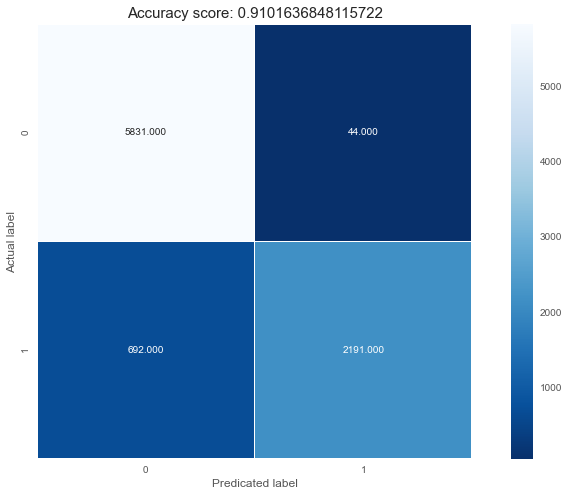

In [114]:
import seaborn as sns

plt.figure(figsize=(14,8))

sns.heatmap(cm, annot =True, fmt = ".3f", linewidths = 0.5, square = True ,cmap = 'Blues_r')

plt.xlabel("Predicated label")
plt.ylabel("Actual label")
title = 'Accuracy score: {0}'.format(score)
plt.title(title, size = 15)

In confusion_matrix
- actual values is rain and predicated rain 1652
- actual values is not rain and predicated rain 20

- actual values is rain and predicated not rain 522
- actual values is not rain and predicated not rain 4373

# Random Forest Classifier

In [119]:

RF =RandomForestClassifier()


In [120]:
#Train the model using the training sets y_pred=clf.predict(X_test)
RF.fit(X_train,y_train)

y_pred=RF.predict(X_test)

In [121]:

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.999885818680064


In [122]:
clf.score(X_train, y_train)

1.0

In [131]:
df.sample()


,DATE,PRCP,TMAX,TMIN,RAIN
12626,1982-07-27,0.0,85,55,False


In [132]:
RF.predict([[0.0,85,55]])

array(['False'], dtype=object)

In [123]:
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


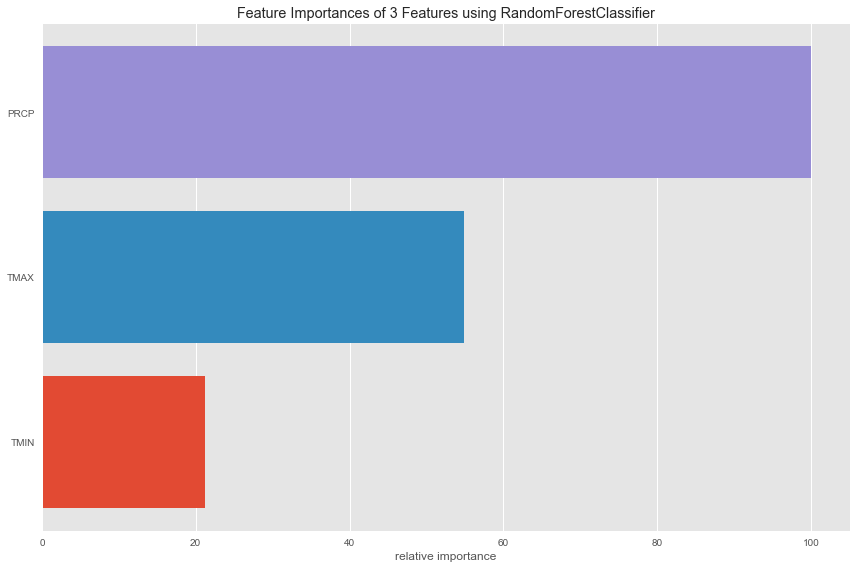

In [124]:
rf = RandomForestClassifier(bootstrap='True', 
                            max_depth=2, 
                            n_jobs=1, 
                            random_state=0,
                            verbose=False)
viz = FeatureImportances(rf)
viz.fit(X_train, y_train)
viz.show();